In [1]:
from IPython.display import IFrame
IFrame('https://www.posttoday.com/social/local/538980', width=1000, height=600)

# อากาศหนาวเย็นและชื้น ทำฝุ่นละอองสะสมเพิ่ม จริงหรือ ?

## ปัจจัยต่าง ๆ มีผลต่อค่า pm2.5 อย่างไร ?
---

#### import modules ต่างๆ ดังนี้

```python 
import pandas as pd #จัดการข้อมูลประเภท data frames
```
```python 
import numpy as np #จัดการข้อมูลในรูปแบบ array หลายมิติ ตัด out liers
```
```python 
import matplotlib #เป็นส่วนการแสดงผลในรูปแบบ visualization เพื่อ plot กราฟ
```
```python 
import matplotlib.pyplot #เป็นส่วนการแสดงผลในรูปแบบ visualization เพื่อ plot กราฟ
```
```python 
import seaborn #ใช้ในการ plot กราฟ
```
```python 
from scipy import stats #ใช้งานฟังก์ชันทางสถิติ
```
```python 
%config InlineBackend.figure_format = 'retina' #เพื่อให้การแสดงผลของกราฟ แบบความละเอียดสูง
```


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker
from scipy import stats
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
print(f'pandas version : {pd.__version__}')
print(f'numpy version : {np.__version__}')
print(f'seaborn version : {sns.__version__}')
print(f'matplotlib version : {matplotlib.__version__}')

pandas version : 0.25.1
numpy version : 1.16.5
seaborn version : 0.9.0
matplotlib version : 3.1.1


#### กำหนด url ที่มาของข้อมูล

In [4]:
url_pm = 'http://berkeleyearth.lbl.gov/air-quality/maps/cities/Thailand/Bangkok/Bangkok.txt'
url_weather = 'https://raw.githubusercontent.com/touchaee/mywork/master/PM2.5/2019final.csv'

#### สร้าง dataframe จาก url_pm

In [5]:
col_names = list('Year, Month, Day, UTC Hour, PM2.5, PM10_mask, Retrospective'.split(', '))
df_pm = pd.read_csv(url_pm, sep = '\t', skiprows = 10, names = col_names)
df_pm.head()

,Year,Month,Day,UTC Hour,PM2.5,PM10_mask,Retrospective
0,2016,3,3,8,62.9,1.0,0
1,2016,3,3,9,62.9,1.0,0
2,2016,3,3,10,55.5,1.0,0
3,2016,3,3,11,55.5,1.0,0
4,2016,3,3,12,47.9,1.0,0


#### สร้าง dataframe จาก url_weather

In [6]:
df_weather = pd.read_csv(url_weather, sep = ',', parse_dates= [0])
df_weather.head()

,date,Time,Temperature (F),Dew Point (F),Humidity (%),Wind,Wind Speed (mph),Wind Gust (mph),Pressure (in),Precip. (in),Condition
0,2019-01-01,00:00:00,75,66,73,NNE,5.0,0.0,30.02,0.0,Fair
1,2019-01-01,00:30:00,75,68,78,NE,2.0,0.0,30.02,0.0,Fair
2,2019-01-01,01:00:00,75,64,69,NNE,7.0,0.0,30.02,0.0,Fair
3,2019-01-01,01:30:00,75,63,65,NNE,8.0,0.0,30.02,0.0,Fair
4,2019-01-01,02:00:00,73,64,73,NE,5.0,0.0,30.02,0.0,Fair


---

# PART1 DF_PM

---

In [7]:
df_pm.head()

,Year,Month,Day,UTC Hour,PM2.5,PM10_mask,Retrospective
0,2016,3,3,8,62.9,1.0,0
1,2016,3,3,9,62.9,1.0,0
2,2016,3,3,10,55.5,1.0,0
3,2016,3,3,11,55.5,1.0,0
4,2016,3,3,12,47.9,1.0,0


เนื่องจากค่า PM10_mask และ Retrospective เป็น one-value column (มีค่าเหมือนกันเกิน 95% หรือมากกว่า) จึงไม่นำมาวิเคราะห์

In [8]:
df_pm.drop(columns= ['PM10_mask', 'Retrospective'], inplace = True)

เปลี่ยนชื่อ columns UTC Hour เป็น Hour เนื่องจาก Datetime รับค่าแค่  year, month, day, hour, minute, second, microsecond และ tzinfo. 

In [9]:
df_pm.rename(columns = {'UTC Hour' : 'Hour'}, inplace = True)

สร้าง column ชื่อ Datetime และแปลง column เวลาให้เป็นเวลาประเทศไทย (UTC+7)  
และการใช้ ฟังก์ชั่น to_datetime และ to_timedelta ทำให้เวลาที่ +7 ชั่วโมงแล้วเกิน 24 จะปัดไปเป็นวันถัดไป

In [10]:
df_pm['Datetime'] = pd.to_datetime(df_pm[['Year', 'Month', 'Day', 'Hour']]) + pd.to_timedelta(7, unit = 'h')
df_pm.head()

,Year,Month,Day,Hour,PM2.5,Datetime
0,2016,3,3,8,62.9,2016-03-03 15:00:00
1,2016,3,3,9,62.9,2016-03-03 16:00:00
2,2016,3,3,10,55.5,2016-03-03 17:00:00
3,2016,3,3,11,55.5,2016-03-03 18:00:00
4,2016,3,3,12,47.9,2016-03-03 19:00:00


---

# PART2 DF_WEATHER

---

In [11]:
df_weather.head()

,date,Time,Temperature (F),Dew Point (F),Humidity (%),Wind,Wind Speed (mph),Wind Gust (mph),Pressure (in),Precip. (in),Condition
0,2019-01-01,00:00:00,75,66,73,NNE,5.0,0.0,30.02,0.0,Fair
1,2019-01-01,00:30:00,75,68,78,NE,2.0,0.0,30.02,0.0,Fair
2,2019-01-01,01:00:00,75,64,69,NNE,7.0,0.0,30.02,0.0,Fair
3,2019-01-01,01:30:00,75,63,65,NNE,8.0,0.0,30.02,0.0,Fair
4,2019-01-01,02:00:00,73,64,73,NE,5.0,0.0,30.02,0.0,Fair


แปลง column time จาก string เป็น time ด้วย to_timedelta

In [12]:
df_weather['Time'] = pd.to_timedelta(df_weather['Time'])

สร้าง column datetime โดย concat 2 column เข้าด้วยกัน

In [13]:
df_weather['Datetime'] = df_weather['date'] + df_weather['Time']
df_weather.head()

,date,Time,Temperature (F),Dew Point (F),Humidity (%),Wind,Wind Speed (mph),Wind Gust (mph),Pressure (in),Precip. (in),Condition,Datetime
0,2019-01-01,00:00:00,75,66,73,NNE,5.0,0.0,30.02,0.0,Fair,2019-01-01 00:00:00
1,2019-01-01,00:30:00,75,68,78,NE,2.0,0.0,30.02,0.0,Fair,2019-01-01 00:30:00
2,2019-01-01,01:00:00,75,64,69,NNE,7.0,0.0,30.02,0.0,Fair,2019-01-01 01:00:00
3,2019-01-01,01:30:00,75,63,65,NNE,8.0,0.0,30.02,0.0,Fair,2019-01-01 01:30:00
4,2019-01-01,02:00:00,73,64,73,NE,5.0,0.0,30.02,0.0,Fair,2019-01-01 02:00:00


# PART3 MERGE DATAFRAME

รวม 2 dataframe ด้วยคำสั่ง merge โดยให้ merge ด้วย column Datetime (Defualt คือการ join แบบ inner)

In [14]:
result = pd.merge(df_pm, df_weather, on = 'Datetime')
result.head()

,Year,Month,Day,Hour,PM2.5,Datetime,date,Time,Temperature (F),Dew Point (F),Humidity (%),Wind,Wind Speed (mph),Wind Gust (mph),Pressure (in),Precip. (in),Condition
0,2018,12,31,17,26.5,2019-01-01 00:00:00,2019-01-01,00:00:00,75,66,73,NNE,5.0,0.0,30.02,0.0,Fair
1,2018,12,31,18,31.0,2019-01-01 01:00:00,2019-01-01,01:00:00,75,64,69,NNE,7.0,0.0,30.02,0.0,Fair
2,2018,12,31,19,27.4,2019-01-01 02:00:00,2019-01-01,02:00:00,73,64,73,NE,5.0,0.0,30.02,0.0,Fair
3,2018,12,31,20,29.6,2019-01-01 03:00:00,2019-01-01,03:00:00,73,64,73,N,5.0,0.0,29.99,0.0,Fair
4,2018,12,31,21,34.3,2019-01-01 04:00:00,2019-01-01,04:00:00,72,63,73,NNE,6.0,0.0,29.99,0.0,Fair


drop column ที่ไม่ต้องการนำมาวิเคราะห์

In [15]:
result.drop(columns = ['Year', 'Month', 'Day', 'Hour','date', 'Time', 'Condition', 'Wind'], inplace = True)

เพื่อความสะดวกในการ plot กราฟ  
กำหนดให้ column datetime เป็น index

In [16]:
result.set_index('Datetime', inplace = True)
result.head()

,PM2.5,Temperature (F),Dew Point (F),Humidity (%),Wind Speed (mph),Wind Gust (mph),Pressure (in),Precip. (in)
Datetime,,,,,,,,
2019-01-01 00:00:00,26.5,75,66,73,5.0,0.0,30.02,0.0
2019-01-01 01:00:00,31.0,75,64,69,7.0,0.0,30.02,0.0
2019-01-01 02:00:00,27.4,73,64,73,5.0,0.0,30.02,0.0
2019-01-01 03:00:00,29.6,73,64,73,5.0,0.0,29.99,0.0
2019-01-01 04:00:00,34.3,72,63,73,6.0,0.0,29.99,0.0


# PART4 CORRELATION

### correlation table
สร้างตาราง correlation table เพื่อดูความสัมพันธ์ของตัวแปรแต่ละตัวแปร

In [17]:
result_corr = result.corr()
result_corr

,PM2.5,Temperature (F),Dew Point (F),Humidity (%),Wind Speed (mph),Wind Gust (mph),Pressure (in),Precip. (in)
PM2.5,1.000000,-0.080867,-0.190303,-0.000594,-0.165122,-0.003243,0.293186,NaN
Temperature (F),-0.080867,1.000000,0.174041,-0.370487,0.360967,0.008372,-0.338050,NaN
Dew Point (F),-0.190303,0.174041,1.000000,0.418739,-0.004834,0.005693,-0.455944,NaN
Humidity (%),-0.000594,-0.370487,0.418739,1.000000,-0.183199,-0.008501,-0.027809,NaN
Wind Speed (mph),-0.165122,0.360967,-0.004834,-0.183199,1.000000,0.160764,-0.307760,NaN
Wind Gust (mph),-0.003243,0.008372,0.005693,-0.008501,0.160764,1.000000,-0.037963,NaN
Pressure (in),0.293186,-0.338050,-0.455944,-0.027809,-0.307760,-0.037963,1.000000,NaN
Precip. (in),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### correlation matrix

cmap คือการกำหนดสีของกราฟงับ

In [18]:
cmap = sns.diverging_palette(h_neg = 0, h_pos = 120, as_cmap = True) 

สร้าง np.array ที่สมาชิกทุกตัวมีค่าเป็น 0 และมีขนาดเท่ากับ result_corr   
จากนั้นน mask สามเหลี่ยมบน(tri-upper)ของ array mask ให้มีค่าเป็น 1

In [19]:
mask=np.zeros_like(result.corr())
mask[np.triu_indices_from(mask)] = True
mask

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [0., 1., 1., 1., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1., 1., 1., 1.],
       [0., 0., 0., 1., 1., 1., 1., 1.],
       [0., 0., 0., 0., 1., 1., 1., 1.],
       [0., 0., 0., 0., 0., 1., 1., 1.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

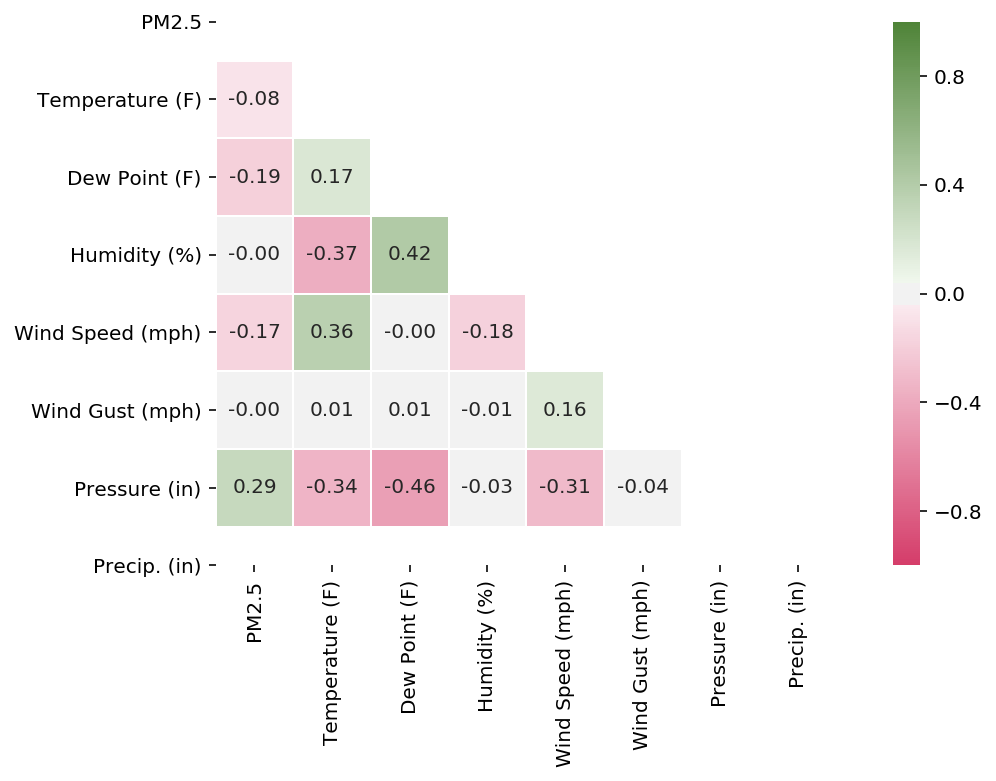

In [20]:
plt.figure(figsize = (10,5))
sns.heatmap(result.corr(), mask=mask, annot=True, linewidths=.5, vmin = -1, vmax = 1, cmap = cmap, fmt = '.2f', square = True, center = 0 )

จะเห็นได้ว่าจากปัจจัยที่เราทำการศึกษา presure เป็นปัจจัยที่มีค่า corrilation กับค่า pm2.5 มากที่สุด

ดังจะเห็นได้จากกราฟแสดงความสัมพันธ์ด้านล่างนี้

# Part5 PROOF

In [27]:
result = pd.merge(df_pm, df_weather, on = 'Datetime')
result.head()

,Year,Month,Day,Hour,PM2.5,Datetime,date,Time,Temperature (F),Dew Point (F),Humidity (%),Wind,Wind Speed (mph),Wind Gust (mph),Pressure (in),Precip. (in),Condition
0,2018,12,31,17,26.5,2019-01-01 00:00:00,2019-01-01,00:00:00,75,66,73,NNE,5.0,0.0,30.02,0.0,Fair
1,2018,12,31,18,31.0,2019-01-01 01:00:00,2019-01-01,01:00:00,75,64,69,NNE,7.0,0.0,30.02,0.0,Fair
2,2018,12,31,19,27.4,2019-01-01 02:00:00,2019-01-01,02:00:00,73,64,73,NE,5.0,0.0,30.02,0.0,Fair
3,2018,12,31,20,29.6,2019-01-01 03:00:00,2019-01-01,03:00:00,73,64,73,N,5.0,0.0,29.99,0.0,Fair
4,2018,12,31,21,34.3,2019-01-01 04:00:00,2019-01-01,04:00:00,72,63,73,NNE,6.0,0.0,29.99,0.0,Fair


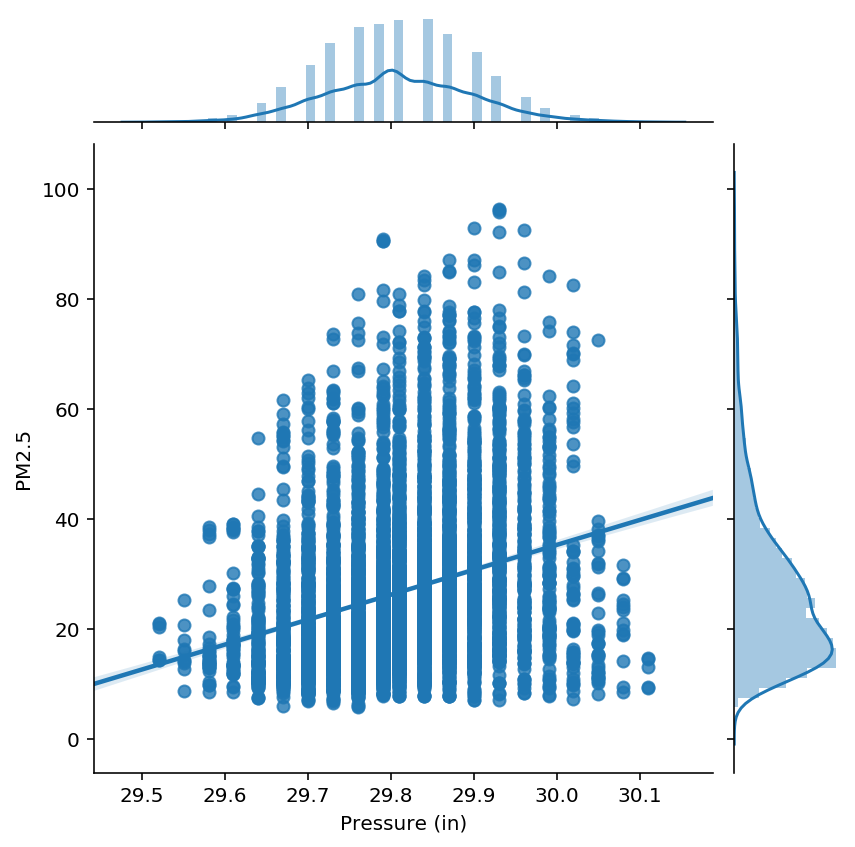

In [28]:
sns.jointplot(x = 'Pressure (in)', y = 'PM2.5', data = result, kind = 'reg')

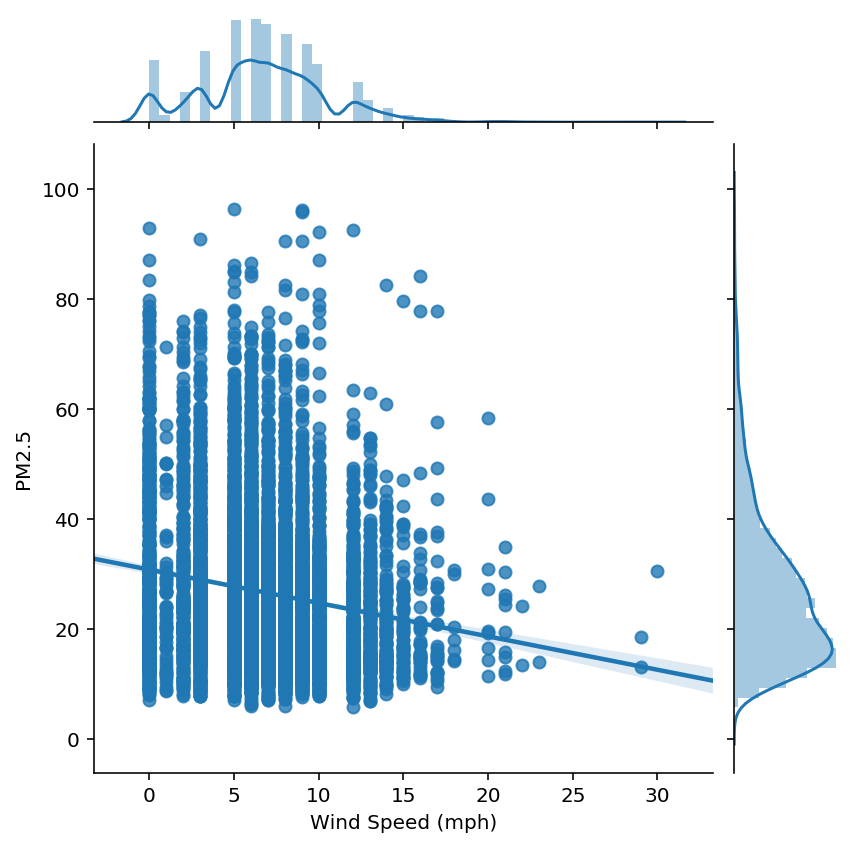

In [29]:
sns.jointplot(x = 'Wind Speed (mph)', y = 'PM2.5', data = result, kind = 'reg')

# PART6 SCIKITLEARN

## LINEAR

In [34]:
from sklearn.linear_model import LinearRegression

In [35]:
result.dropna(inplace = True)
model = LinearRegression()
model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
X = result[['Temperature (F)']]
y = result['PM2.5']

In [48]:
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [49]:
model.score(X, y)

0.006582824464913538

In [24]:
import statsmodels.api as sm

In [25]:
X2 = sm.add_constant(X)

C:\Users\kitit\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [26]:
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  PM2.5   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     177.4
Date:                Wed, 05 Feb 2020   Prob (F-statistic):          7.77e-145
Time:                        09:02:38   Log-Likelihood:                -27393.
No. Observations:                6864   AIC:                         5.480e+04
Df Residuals:                    6859   BIC:                         5.483e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -1174.6886     64.219    -